In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

from sklearn.model_selection import RandomizedSearchCV

In [2]:
raw_data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00471/Data_for_UCI_named.csv')
raw_data.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [3]:
raw_data.describe(include='all')

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unstable
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6380
mean,5.250000,5.250001,5.250004,5.249997,3.750000,-1.250000,-1.250000,-1.250000,0.525000,0.525000,0.525000,0.525000,0.015731,NaN
std,2.742548,2.742549,2.742549,2.742556,0.752160,0.433035,0.433035,0.433035,0.274256,0.274255,0.274255,0.274255,0.036919,NaN
min,0.500793,0.500141,0.500788,0.500473,1.582590,-1.999891,-1.999945,-1.999926,0.050009,0.050053,0.050054,0.050028,-0.080760,NaN
25%,2.874892,2.875140,2.875522,2.874950,3.218300,-1.624901,-1.625025,-1.624960,0.287521,0.287552,0.287514,0.287494,-0.015557,NaN
50%,5.250004,5.249981,5.249979,5.249734,3.751025,-1.249966,-1.249974,-1.250007,0.525009,0.525003,0.525015,0.525002,0.017142,NaN
75%,7.624690,7.624893,7.624948,7.624838,4.282420,-0.874977,-0.875043,-0.875065,0.762435,0.762490,0.762440,0.762433,0.044878,NaN


Stability of the Grid System
Electrical grids require a balance between electricity supply and demand in order to be stable. Conventional systems achieve this balance through demand-driven electricity production. For future grids with a high share of inflexible (i.e., renewable) energy source, the concept of demand response is a promising solution. This implies changes in electricity consumption in relation to electricity price changes. In this work, we’ll build a binary classification model to predict if a grid is stable or unstable using the UCI Electrical Grid Stability Simulated dataset.

Dataset: https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simulated+Data+

It has 12 primary predictive features and two dependent variables.

Predictive features:

'tau1' to 'tau4': the reaction time of each network participant, a real value within the range 0.5 to 10 ('tau1' corresponds to the supplier node, 'tau2' to 'tau4' to the consumer nodes);
'p1' to 'p4': nominal power produced (positive) or consumed (negative) by each network participant, a real value within the range -2.0 to -0.5 for consumers ('p2' to 'p4'). As the total power consumed equals the total power generated, p1 (supplier node) = - (p2 + p3 + p4);
'g1' to 'g4': price elasticity coefficient for each network participant, a real value within the range 0.05 to 1.00 ('g1' corresponds to the supplier node, 'g2' to 'g4' to the consumer nodes; 'g' stands for 'gamma');
Dependent variables:

'stab': the maximum real part of the characteristic differential equation root (if positive, the system is linearly unstable; if negative, linearly stable);
'stabf': a categorical (binary) label ('stable' or 'unstable').
Because of the direct relationship between 'stab' and 'stabf' ('stabf' = 'stable' if 'stab' <= 0, 'unstable' otherwise), 'stab' should be dropped and 'stabf' will remain as the sole dependent variable (binary classification).

Split the data into an 80-20 train-test split with a random state of “1”. Use the standard scaler to transform the train set (x_train, y_train) and the test set (x_test). Use scikit learn to train a random forest and extra trees classifier. And use xgboost and lightgbm to train an extreme boosting model and a light gradient boosting model. Use random_state = 1 for training all models and evaluate on the test set. 

Also, to improve the Extra Trees Classifier, you will use the following parameters (number of estimators, minimum number of samples, minimum number of samples for leaf node and the number of features to consider when looking for the best split) for the hyperparameter grid needed to run a Randomized Cross Validation Search (RandomizedSearchCV). 

n_estimators = [50, 100, 300, 500, 1000]

min_samples_split = [2, 3, 5, 7, 9]

min_samples_leaf = [1, 2, 4, 6, 8]

max_features = ['auto', 'sqrt', 'log2', None] 

hyperparameter_grid = {'n_estimators': n_estimators,

                       'min_samples_leaf': min_samples_leaf,

                       'min_samples_split': min_samples_split,

                       'max_features': max_features}

In [4]:
raw_data.isnull().sum()

tau1     0
tau2     0
tau3     0
tau4     0
p1       0
p2       0
p3       0
p4       0
g1       0
g2       0
g3       0
g4       0
stab     0
stabf    0
dtype: int64

In [5]:
raw_data.stabf.value_counts()

unstable    6380
stable      3620
Name: stabf, dtype: int64

In [6]:
encoder = LabelEncoder()
raw_data['stabf'] = encoder.fit_transform(raw_data['stabf'])

In [7]:
X = raw_data.drop(columns=['stabf','stab'])
y = raw_data['stabf']

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [9]:
y_train.value_counts() #1 is unstable, 0 is stable

1    5092
0    2908
Name: stabf, dtype: int64

In [10]:
scaler = StandardScaler()

In [11]:
normalised_train_df = scaler.fit_transform(x_train)
normalised_train_df = pd.DataFrame(normalised_train_df, columns=x_train.columns)
normalised_train_df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
0,0.367327,-0.986042,0.650447,1.547527,-0.291490,0.061535,1.293862,-0.845074,0.160918,0.339859,0.585568,0.492239
1,-0.064659,0.089437,1.035079,-1.641494,0.619865,-0.067235,-1.502925,0.486613,-0.293143,-1.558488,1.429649,-1.443521
2,-1.467850,1.298418,-0.502536,1.166046,-0.180521,0.490603,0.682560,-0.855302,1.399350,1.451534,-1.045743,0.492489
3,0.820081,0.529920,1.299657,-1.141975,-0.812854,-0.763632,1.521579,0.658780,-0.958319,1.361958,1.604140,0.275303
4,0.665424,-1.425627,0.312300,0.919137,-1.614296,0.760315,1.422019,0.639243,1.676895,0.695660,1.137504,-1.312575


In [12]:
x_test.reset_index(drop=True, inplace=True)
normalised_test_df = scaler.transform(x_test)
normalised_test_df = pd.DataFrame(normalised_test_df, columns=x_test.columns)
normalised_test_df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
0,0.593951,-0.412733,1.503924,1.116943,0.403423,-1.492971,-0.785033,1.566781,-0.901007,1.167203,-1.507330,1.084726
1,0.202190,0.374416,-0.188800,-0.522268,-0.225967,-1.058483,0.420047,1.028627,-1.625721,-0.395660,1.414651,1.226011
2,-1.079044,-0.313745,-0.884634,0.017080,-0.943122,0.112653,0.801335,0.733004,1.457108,-1.438495,0.651821,-1.682168
3,-0.083120,-1.107327,0.372805,-1.708152,0.753990,-1.637972,0.403805,-0.088036,0.083322,-1.672322,-0.357714,1.055865
4,0.873921,1.438466,0.086662,1.715037,-0.153880,-0.007015,-0.197053,0.472315,0.136549,-1.469731,0.956396,-0.819727


## Extra Trees

In [13]:
etc = ExtraTreesClassifier(random_state = 1)
etc.fit(normalised_train_df, y_train)

ExtraTreesClassifier(random_state=1)

In [14]:
etc_pred = etc.predict(normalised_test_df)

In [15]:
etc_cm = confusion_matrix(y_test, etc_pred)
print(etc_cm)
round(accuracy_score(y_test, etc_pred),4)

[[ 606  106]
 [  38 1250]]


0.928

In [16]:
print(classification_report(y_test, etc_pred))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89       712
           1       0.92      0.97      0.95      1288

    accuracy                           0.93      2000
   macro avg       0.93      0.91      0.92      2000
weighted avg       0.93      0.93      0.93      2000



## Random Forest

In [17]:
rf = RandomForestClassifier(random_state = 1)
rf.fit(normalised_train_df, y_train)

RandomForestClassifier(random_state=1)

In [18]:
rf_pred = rf.predict(normalised_test_df)

In [19]:
rf_cm = confusion_matrix(y_test, rf_pred)
print(rf_cm)
round(accuracy_score(y_test, rf_pred),4)

[[ 625   87]
 [  55 1233]]


0.929

In [20]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       712
           1       0.93      0.96      0.95      1288

    accuracy                           0.93      2000
   macro avg       0.93      0.92      0.92      2000
weighted avg       0.93      0.93      0.93      2000



## XGBoost

In [21]:
xgb = XGBClassifier(random_state = 1)
xgb.fit(normalised_train_df, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [22]:
xgb_pred = xgb.predict(normalised_test_df)

In [23]:
xgb_cm = confusion_matrix(y_test, xgb_pred)
print(xgb_cm)
round(accuracy_score(y_test, xgb_pred),4)

[[ 648   64]
 [  45 1243]]


0.9455

In [24]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       712
           1       0.95      0.97      0.96      1288

    accuracy                           0.95      2000
   macro avg       0.94      0.94      0.94      2000
weighted avg       0.95      0.95      0.95      2000



## Lightgbm

In [25]:
lgbm = LGBMClassifier(random_state = 1)
lgbm.fit(normalised_train_df, y_train)

LGBMClassifier(random_state=1)

In [26]:
lgbm_pred = lgbm.predict(normalised_test_df)

In [27]:
lgbm_cm = confusion_matrix(y_test, lgbm_pred)
print(lgbm_cm)
round(accuracy_score(y_test, lgbm_pred),4)

[[ 635   77]
 [  48 1240]]


0.9375

In [28]:
print(classification_report(y_test, lgbm_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91       712
           1       0.94      0.96      0.95      1288

    accuracy                           0.94      2000
   macro avg       0.94      0.93      0.93      2000
weighted avg       0.94      0.94      0.94      2000



## Randomized Search CV

In [29]:
n_estimators = [50, 100, 300, 500, 1000]
min_samples_split = [2, 3, 5, 7, 9]
min_samples_leaf = [1, 2, 4, 6, 8]
max_features = ['auto', 'sqrt', 'log2', None]

hyperparameter_grid = {'n_estimators': n_estimators,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features}

In [30]:
random_search = RandomizedSearchCV(estimator = etc,
                                   param_distributions = hyperparameter_grid,
                                   scoring = 'accuracy', 
                                   cv = 5,
                                   verbose = 1,
                                   n_iter = 10,
                                   random_state = 1,
                                   n_jobs = -1) 

random_search.fit(normalised_train_df, y_train)
best_accuracy = random_search.best_score_
best_parameters = random_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


Best Accuracy: 92.41 %
Best Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 8, 'max_features': None}


In [31]:
etc_2 = ExtraTreesClassifier(n_estimators = 1000, min_samples_split = 2, min_samples_leaf = 8, 
                             max_features = None, random_state = 1)
etc_2.fit(normalised_train_df, y_train)

ExtraTreesClassifier(max_features=None, min_samples_leaf=8, n_estimators=1000,
                     random_state=1)

In [32]:
etc_pred_2 = etc_2.predict(normalised_test_df)

In [33]:
etc_cm_2 = confusion_matrix(y_test, etc_pred_2)
print(etc_cm_2)
round(accuracy_score(y_test, etc_pred_2),4)

[[ 619   93]
 [  53 1235]]


0.927

In [34]:
feature_importance = etc.feature_importances_
#feature_importance_normalized = np.std([tree.feature_importances_ for tree in etc.estimators_], axis = 0)

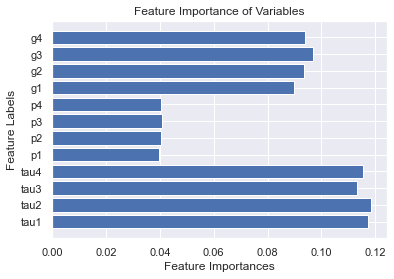

In [35]:
plt.barh(normalised_train_df.columns, feature_importance)
plt.xlabel('Feature Importances')
plt.ylabel('Feature Labels')
plt.title('Feature Importance of Variables')
plt.show()